In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils.data import load_df
import warnings 
warnings.filterwarnings('ignore')
from utils.data import create_sequences
from sklearn.preprocessing import StandardScaler
from utils.metrics import mar, far, f1_score

from models.lstm_ae import LSTM_AE


In [3]:
from utils.pipeline import Pipeline, Predictor

class Config:
    train_size = 400
    TIME_STEPS = 50
    epochs = 1
    batch_size = 10 
    Q = 0.99
    
conf = Config

class LSTM_AE_Predictor(Predictor):
    def __str__(self): return "LSTM-AE"
    def make_prediction(self, df):
        ss = StandardScaler()
        x_train = np.array(ss.fit_transform(df[:conf.train_size].drop(['anomaly','changepoint'], axis=1)))
        x_train = create_sequences(x_train, conf.TIME_STEPS)
        
        model = LSTM_AE()
        model.fit(x_train, conf.epochs, conf.batch_size, conf.TIME_STEPS)
        
        health_r = pd.Series(np.sum(np.mean(np.abs(model.predict(x_train) - x_train), axis=1), axis=1))
        UCL = health_r.quantile(conf.Q)
        
        x_test = df.drop(['anomaly','changepoint'], axis=1)
        x_test = np.array(ss.transform(x_test))
        x_test = create_sequences(x_test, conf.TIME_STEPS)
        
        r = pd.Series(np.sum(np.mean(np.abs(model.predict(x_test) - x_test), axis=1), axis=1))        
        anomalous_data = r > (3/2 * UCL)
        anomalous_data_indices = [] 
        for data_idx in range(conf.TIME_STEPS - 1, len(x_test) - conf.TIME_STEPS + 1):
            if np.all(anomalous_data[data_idx - conf.TIME_STEPS + 1 : data_idx]):
                anomalous_data_indices.append(data_idx - int(conf.TIME_STEPS // 6))
        prediction = pd.Series(data=0, index=df.index)
        prediction.iloc[anomalous_data_indices] = 1
        return prediction
        


In [4]:
class Config:
    train_size = 400
    TIME_STEPS = 50
    epochs = 2
    batch_size = 32
    Q = 0.99
from models.lstm_ad import LSTM_AD
  
class LSTM_AD_Predictor(Predictor):
    def __str__(self): return "LSTM-AD"
    
    def make_prediction(self, df):
        
        SS = StandardScaler()
        df = df.drop(['anomaly','changepoint'], axis=1)
             
        x_train = np.array(SS.fit_transform(df[:Config.train_size]))
        x_train = create_sequences(x_train, Config.TIME_STEPS)

        lstm_ad = LSTM_AD().fit(x_train)
        x_test = np.array(SS.transform(df))
        x_test = create_sequences(x_test, Config.TIME_STEPS)

        predictions = lstm_ad.predict(x_test)

        r = pd.Series(np.sum(np.mean(np.abs(np.array(predictions) - x_test), axis=1), axis=1))
        health_r = r[:Config.train_size]
        
        UCL = health_r.quantile(Config.Q)
        anomalous_data = r > (3/2 * UCL)

        anomalous_data_indices = [] 
        for data_idx in range(Config.TIME_STEPS - 1, len(x_test) - Config.TIME_STEPS + 1):
            if np.all(anomalous_data[data_idx - Config.TIME_STEPS + 1 : data_idx]):
                anomalous_data_indices.append(data_idx - int(Config.TIME_STEPS // 6))

        prediction = pd.Series(data=0, index=df.index)
        prediction.iloc[anomalous_data_indices] = 1
        return prediction

In [5]:
from utils.pipeline import Pipeline, Predictor
from models.mset import MSET

In [6]:
class MsetPredictor(Predictor):
    def make_prediction(self, df):
        
        train_size = 400
        window_size = 40

        # We know that 35% it is anomalies
        quantile_value = 0.6

        df = df.drop(['anomaly','changepoint'], axis=1)

        mset = MSET()
        mset.fit(df[:train_size])

        y_pred = mset.predict(df)

        err = np.linalg.norm((y_pred.T - df), axis=1)
        rel_err = movmean(err/np.linalg.norm(y_pred.T, axis=1), window=window_size)
        UCL = pd.Series(rel_err).quantile(quantile_value)

        prediction = pd.DataFrame((rel_err > UCL), df.index).fillna(0).any(axis=1).astype(int)
        return prediction

In [7]:
df = pd.read_csv("./data/valve1/0.csv", sep=";", parse_dates=True, index_col="datetime")

df.sort_index(inplace=True)

In [8]:
predictors = [
    LSTM_AE_Predictor(),
    LSTM_AD_Predictor(),
]
predictions = []
for predictor in predictors:
    predictions.append((predictor.__str__(), predictor.make_prediction(df)))
    

36/36 [==============================] - 10s 133ms/step - loss: 0.8928
Epoch 1/2
11/11 [==============================] - 5s 111ms/step - loss: 0.8931
Epoch 2/2
11/11 [==============================] - 1s 111ms/step - loss: 0.7753


In [9]:
colors=["orange","green","blue", "red","magenta"]

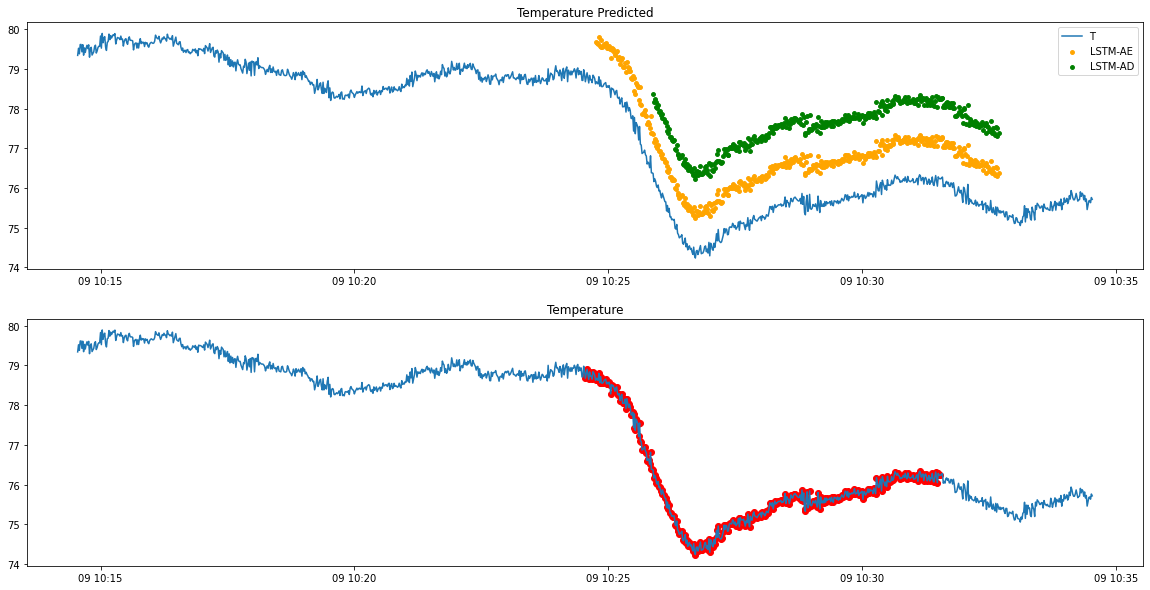

In [10]:
y_test = df.anomaly
fig, axs = plt.subplots(2, 1, figsize=(20,10))
temperatures = df.Temperature
axs[0].plot(temperatures)
axs[1].plot(temperatures)

for i, (predictor, prediction) in enumerate(predictions):
    y = pd.Series(prediction)
    anomalies_indecies = y.index[y == 1]
    axs[0].scatter(anomalies_indecies, i +1 + temperatures[anomalies_indecies], s=15, color=colors[i])

axs[0].set_title("Temperature Predicted")
axs[0].legend(["T"]+[p for (p,_) in predictions])

y = pd.Series(y_test)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], temperatures[anomalies_indecies], color='r')
axs[1].set_title("Temperature")

plt.show()